# Chapter 3

This notebook contains the commands that are shown in the lecture 3.

In [1]:
library(tidyverse)
library(lubridate)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date



## Grouping data by a common variable

### Description of data - Triton cluster file statistics

[read_table2](https://readr.tidyverse.org/reference/read_table.html)

In [2]:
load_filesizes <- function(filesizes_file){
    filesizes <- read_table2(filesizes_file, col_names=c('Bytes','MonthsTo2021', 'Files'))
    
    filesizes <- filesizes %>%
        # Remove empty files
        filter(Bytes != 0) %>%
        # Create a column for log2 of bytes
        mutate(BytesLog2 = log2(Bytes)) %>%
        # Determine total space S used by N files of size X during date D: S=N*X 
        mutate(SpaceUsage = Bytes*Files) %>%
        # Determine file year and month from the MonthsTo2021-column
        mutate(
            TotalMonths = 2021*12 - MonthsTo2021 - 1,
            Year = TotalMonths %/% 12,
            Month = TotalMonths %% 12 +1,
            Day = 1
        )

     # Set year for really old files and files with incorrect timestamps
    invalid_years = c((filesizes['Year'] < 2010) | (filesizes['Year'] > 2020))
    filesizes[invalid_years, c('Year','Month')] <- NaN
    
    # Get month names for the correct ordering of Month categories
    month_names <- month(seq(1,12), label=TRUE, locale='C')
    filesizes <- filesizes %>%
        mutate(
            # Create Date and get the name for the month
            Date = make_datetime(Year, Month, Day),
            # Set Month 
            Month=month(Month, label=TRUE, locale='C'),
            # Set Month to be an ordered categorical with predefined levels 
            Month=factor(Month, ordered=TRUE, levels=month_names))
    filesizes <- filesizes %>%
        # Sort data based on Date and BytesLog2
        arrange(Date, BytesLog2) %>%
        # Remove old columns
        select(-MonthsTo2021,-TotalMonths,-Day)
    return(filesizes)
}

filesizes <- load_filesizes('../data/filesizes_timestamps.txt')
head(filesizes)

Parsed with column specification:
cols(
  Bytes = col_double(),
  MonthsTo2021 = col_double(),
  Files = col_double()
)


Bytes,Files,BytesLog2,SpaceUsage,Year,Month,Date
1,5,0,5,2010,Jan,2010-01-01
2,3,1,6,2010,Jan,2010-01-01
4,27,2,108,2010,Jan,2010-01-01
8,136,3,1088,2010,Jan,2010-01-01
16,208,4,3328,2010,Jan,2010-01-01
32,653,5,20896,2010,Jan,2010-01-01


### Simple groupings and summaries - Calculating new files per year

In [3]:
newfiles_relevant <- filesizes %>%
    # Drop rows with NaNs (invalid years)
    drop_na() %>%
    # Pick relevant columns
    select(Year, Files) %>%
    # Change year to category for prettier plotting
    mutate(Year=as.factor(Year))
head(newfiles_relevant)

Year,Files
2010,5
2010,3
2010,27
2010,136
2010,208
2010,653


In [4]:
glimpse(newfiles_relevant)

newfiles_yearly_sum <- newfiles_relevant %>%
    group_by(Year) %>%
    summarize(Files=sum(Files))

glimpse(newfiles_yearly_sum)
head(newfiles_yearly_sum)

Observations: 4,698
Variables: 2
$ Year  <fct> 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 201…
$ Files <dbl> 5, 3, 27, 136, 208, 653, 934, 824, 1679, 2151, 3056, 4642, 3649…
Observations: 11
Variables: 2
$ Year  <fct> 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020
$ Files <dbl> 5590287, 13197038, 17099900, 14755151, 26329321, 24896331, 4368…


Year,Files
2010,5590287
2011,13197038
2012,17099900
2013,14755151
2014,26329321
2015,24896331


In [5]:
newfiles_yearly_sum <- newfiles_yearly_sum %>%
    ungroup()

head(newfiles_yearly_sum)

Year,Files
2010,5590287
2011,13197038
2012,17099900
2013,14755151
2014,26329321
2015,24896331


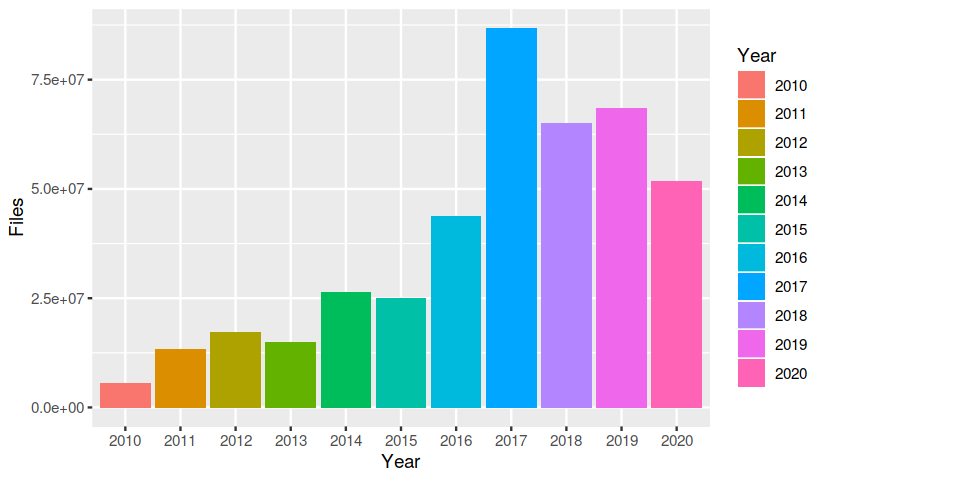

In [6]:
options(repr.plot.width=8, repr.plot.height=4)

newfiles_yearly_sum %>%
    ggplot(aes(x=Year, y=Files, fill=Year)) +
    geom_col()

### Creating a function for many different summaries

In [7]:
aggregate_filesize_data <- function(data, grouping, target, agg_function) {
    data_relevant <- data %>%
        # Drop rows with NaNs (invalid years)
        drop_na() %>%
        # Pick relevant columns
        select_at(vars(c(grouping, target))) %>%
        # Change grouping to category for prettier plotting
        mutate_at(vars(grouping), as.factor)

    # Aggregate data
    data_aggregated <- data_relevant %>%
        group_by_at((grouping)) %>%
        summarize_at(vars(target), agg_function) %>%
        ungroup()

    return(data_aggregated)
}

Year,Files,SpaceUsage
2010,5590287,"2,260716e+12"
2011,13197038,"7,000732e+12"
2012,17099900,"1,547558e+13"
2013,14755151,"1,544538e+13"
2014,26329321,"4,253036e+13"
2015,24896331,"3,096538e+13"


Month,Files,SpaceUsage
Jan,34921070,"4,313122e+13"
Feb,35707864,"7,102250e+13"
Mar,25494722,"5,651687e+13"
Apr,31224476,"7,538209e+13"
May,37816173,"7,533862e+13"
Jun,33804495,"7,010947e+13"


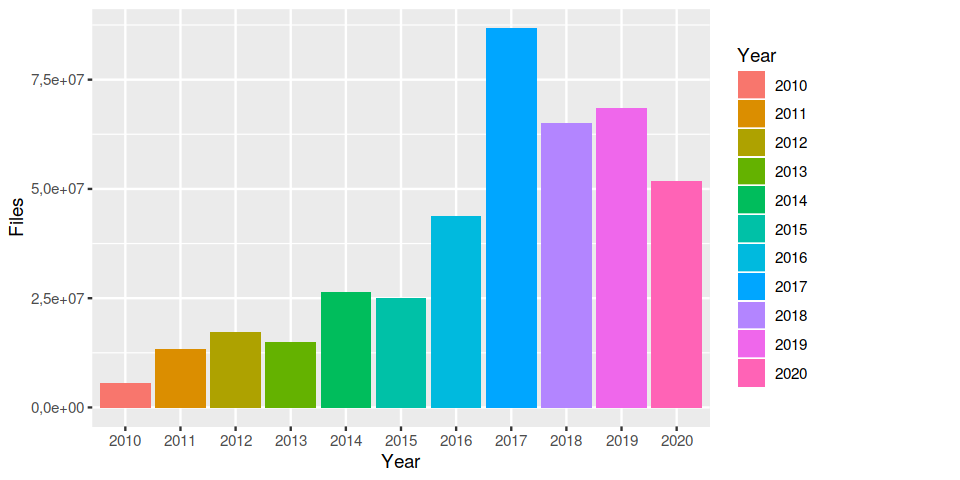

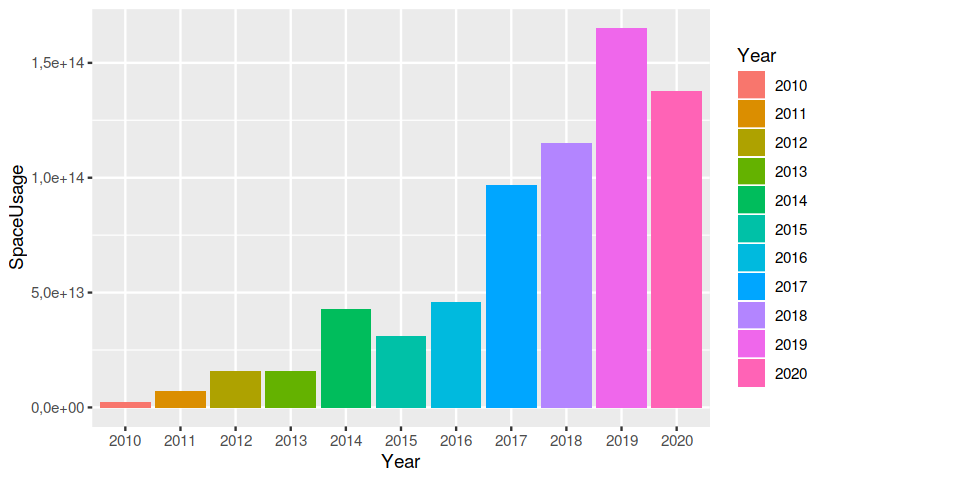

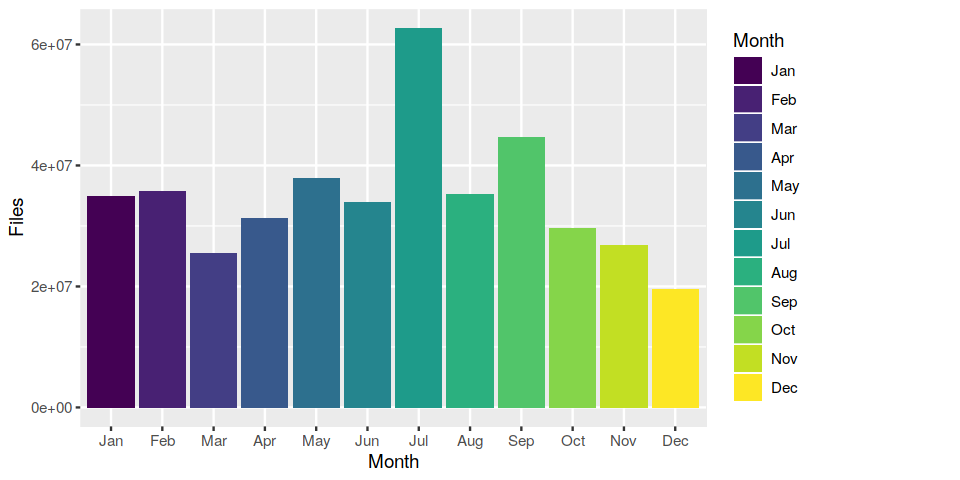

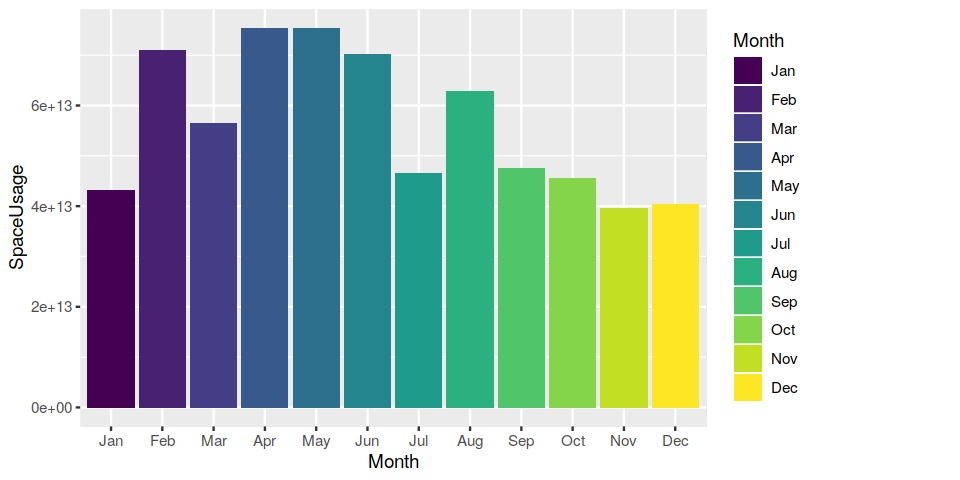

In [8]:
options(repr.plot.width=8, repr.plot.height=4)

yearly_sum <- aggregate_filesize_data(filesizes, c('Year'), c('Files', 'SpaceUsage'), sum)
monthly_sum <- aggregate_filesize_data(filesizes, c('Month'), c('Files', 'SpaceUsage'), sum)

head(yearly_sum)
head(monthly_sum)

print(yearly_sum %>%
    ggplot(aes(x=Year, y=Files, fill=Year)) +
    geom_col())
print(yearly_sum %>%
    ggplot(aes(x=Year, y=SpaceUsage, fill=Year)) +
    geom_col())
print(monthly_sum %>%
    ggplot(aes(x=Month, y=Files, fill=Month)) +
    geom_col())
print(monthly_sum %>%
    ggplot(aes(x=Month, y=SpaceUsage, fill=Month)) +
    geom_col())

## Using bootstrapping/resampling methods for the calculation of statistical moments

### Quick overview of bootstrapping

In [9]:
newfiles_relevant2 <- filesizes %>%
    # Drop rows with NaNs (invalid years)
    drop_na() %>%
    # Pick relevant columns
    select(Year, BytesLog2, Files) %>%
    # Aggregate based on Year and BytesLog2
    group_by(Year, BytesLog2) %>%
    summarize(Files=sum(Files))

head(newfiles_relevant2)

Year,BytesLog2,Files
2010,0,124
2010,1,1632
2010,2,5626
2010,3,26287
2010,4,65074
2010,5,202543


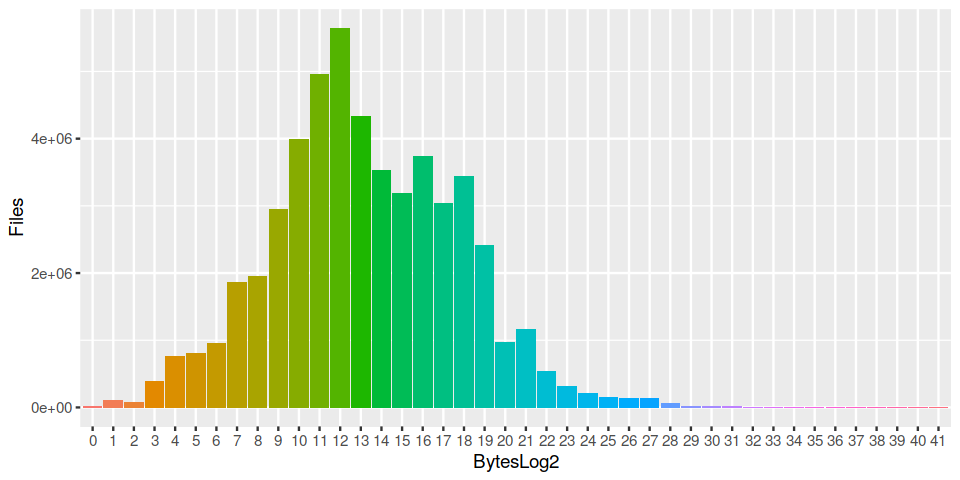

In [10]:
options(repr.plot.width=8, repr.plot.height=4)

yearly_bytes_sum <- aggregate_filesize_data(filesizes, c('Year','BytesLog2'), c('Files', 'SpaceUsage'), sum)

bytes_2020 <- yearly_bytes_sum %>%
    filter(Year == 2020)

bytes_2020 %>%
    ggplot(aes(x=BytesLog2, y=Files, fill=BytesLog2)) +
    geom_col() +
    theme(legend.position = "none")

In [11]:
# Pick target data column and convert it to integer
# IMPORTANT:
#    Do notice that we'll have to first convert our target
#    into characters as we do not want convert factor ENCODING,
#    but the actual decoded DATA
target_data <- as.numeric(as.character(bytes_2020[['BytesLog2']]))

# Pick weight data column
weight_data <- bytes_2020[['Files']]

# Normalize weight_data into probabilities
weight_data <- weight_data/sum(weight_data)

print(head(target_data))
print(head(weight_data))

[1] 0 1 2 3 4 5
[1] 0,0003271367 0,0019404559 0,0014705603 0,0074056601 0,0145700668
[6] 0,0156263905


In [12]:
# Create means vector
means <- numeric(10)
for (i in seq(10)) {
    # Calculate resampled mean
    means[[i]] <- mean(sample(target_data, 100, replace=TRUE, prob=weight_data))
}
print(means)
print(paste0('Estimated sample mean: ', mean(means)))

 [1] 13,39 13,52 13,19 12,78 12,44 14,29 12,33 13,74 12,98 12,86
[1] "Estimated sample mean: 13,152"


In [13]:
get_bootstrapped_means <- function(dataset, target_col, weight_col, n_means=1000) {
    # Pick relevant columns
    # Pick target data column and convert it to integer
    target_data <- as.numeric(as.character(dataset[[target_col]]))
    # Pick weight data column
    weight_data <- dataset[[weight_col]]
    weight_data <- weight_data/sum(weight_data)

    # Create means vector
    means <- numeric(n_means)
    for (i in seq(n_means)) {
        # Calculate resampled mean
        means[[i]] <- mean(sample(target_data, 100, replace=TRUE, prob=weight_data))
    }
    means <- tibble(SampledMeans=means)
    return(means)
}

means <- get_bootstrapped_means(bytes_2020, 'BytesLog2', 'Files', n_means=1000)
print(head(means))
print(paste0('Estimated sample mean: ', mean(means[['SampledMeans']])))

# A tibble: 6 x 1
  SampledMeans
         <dbl>
1         13.3
2         13.0
3         12.8
4         13.1
5         12.9
6         12.7
[1] "Estimated sample mean: 13,23812"


### Using nested dataframes to help with bootstrapping

In [14]:
yearly_bytes_sum_nested <- yearly_bytes_sum %>%
    group_by(Year) %>%
    nest()

print(glimpse(yearly_bytes_sum_nested))

bootstrapped_means <- yearly_bytes_sum_nested %>%
    mutate(SampledMeans=map(data, function(x) get_bootstrapped_means(x, 'BytesLog2', 'Files', n_means=100))) %>%
    select(-data)

print(glimpse(bootstrapped_means))
head(bootstrapped_means,1)

Observations: 11
Variables: 2
$ Year <fct> 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020
$ data <list> [<tbl_df[37 x 3]>, <tbl_df[37 x 3]>, <tbl_df[38 x 3]>, <tbl_df[…
# A tibble: 11 x 2
   Year  data             
   <fct> <list>           
 1 2010  <tibble [37 × 3]>
 2 2011  <tibble [37 × 3]>
 3 2012  <tibble [38 × 3]>
 4 2013  <tibble [38 × 3]>
 5 2014  <tibble [40 × 3]>
 6 2015  <tibble [40 × 3]>
 7 2016  <tibble [40 × 3]>
 8 2017  <tibble [40 × 3]>
 9 2018  <tibble [42 × 3]>
10 2019  <tibble [40 × 3]>
11 2020  <tibble [42 × 3]>
Observations: 11
Variables: 2
$ Year         <fct> 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 20…
$ SampledMeans <list> [<tbl_df[100 x 1]>, <tbl_df[100 x 1]>, <tbl_df[100 x 1]…
# A tibble: 11 x 2
   Year  SampledMeans      
   <fct> <list>            
 1 2010  <tibble [100 × 1]>
 2 2011  <tibble [100 × 1]>
 3 2012  <tibble [100 × 1]>
 4 2013  <tibble [100 × 1]>
 5 2014  <tibble [100 × 1]>
 6 2015  <tibble [100 × 1]>
 7 2016  <ti

Year,SampledMeans
2010,"12,64, 13,79, 12,88, 13,42, 13,50, 13,33, 12,77, 13,53, 12,14, 12,97, 13,22, 13,04, 12,89, 13,33, 13,27, 12,84, 12,64, 12,87, 13,00, 12,51, 12,89, 13,38, 12,63, 13,53, 13,40, 13,02, 12,82, 12,75, 13,22, 12,96, 13,01, 12,97, 13,22, 13,07, 12,18, 12,22, 13,08, 12,73, 12,20, 13,22, 12,53, 13,00, 13,00, 13,50, 13,02, 12,83, 12,99, 12,97, 12,99, 13,04, 12,46, 13,08, 12,53, 12,80, 13,16, 13,28, 12,82, 13,18, 12,82, 13,63, 12,46, 12,82, 12,11, 13,08, 13,24, 12,53, 13,34, 13,00, 12,83, 12,38, 12,83, 13,14, 13,08, 13,26, 13,01, 13,32, 13,20, 13,62, 12,87, 12,35, 12,72, 13,20, 12,42, 13,40, 13,44, 13,86, 13,51, 12,91, 12,76, 12,46, 13,25, 13,00, 13,27, 13,06, 13,51, 12,84, 13,29, 13,44, 12,83, 13,96"


In [15]:
bootstrapped_means <- bootstrapped_means  %>%
    mutate(Means=map(SampledMeans, function(x) mean(x[['SampledMeans']])))

print(glimpse(bootstrapped_means))
head(bootstrapped_means, 1)

Observations: 11
Variables: 3
$ Year         <fct> 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 20…
$ SampledMeans <list> [<tbl_df[100 x 1]>, <tbl_df[100 x 1]>, <tbl_df[100 x 1]…
$ Means        <list> [13,0031, 14,0278, 10,586, 13,4229, 14,0442, 11,678, 13…
# A tibble: 11 x 3
   Year  SampledMeans       Means    
   <fct> <list>             <list>   
 1 2010  <tibble [100 × 1]> <dbl [1]>
 2 2011  <tibble [100 × 1]> <dbl [1]>
 3 2012  <tibble [100 × 1]> <dbl [1]>
 4 2013  <tibble [100 × 1]> <dbl [1]>
 5 2014  <tibble [100 × 1]> <dbl [1]>
 6 2015  <tibble [100 × 1]> <dbl [1]>
 7 2016  <tibble [100 × 1]> <dbl [1]>
 8 2017  <tibble [100 × 1]> <dbl [1]>
 9 2018  <tibble [100 × 1]> <dbl [1]>
10 2019  <tibble [100 × 1]> <dbl [1]>
11 2020  <tibble [100 × 1]> <dbl [1]>


Year,SampledMeans,Means
2010,"12,64, 13,79, 12,88, 13,42, 13,50, 13,33, 12,77, 13,53, 12,14, 12,97, 13,22, 13,04, 12,89, 13,33, 13,27, 12,84, 12,64, 12,87, 13,00, 12,51, 12,89, 13,38, 12,63, 13,53, 13,40, 13,02, 12,82, 12,75, 13,22, 12,96, 13,01, 12,97, 13,22, 13,07, 12,18, 12,22, 13,08, 12,73, 12,20, 13,22, 12,53, 13,00, 13,00, 13,50, 13,02, 12,83, 12,99, 12,97, 12,99, 13,04, 12,46, 13,08, 12,53, 12,80, 13,16, 13,28, 12,82, 13,18, 12,82, 13,63, 12,46, 12,82, 12,11, 13,08, 13,24, 12,53, 13,34, 13,00, 12,83, 12,38, 12,83, 13,14, 13,08, 13,26, 13,01, 13,32, 13,20, 13,62, 12,87, 12,35, 12,72, 13,20, 12,42, 13,40, 13,44, 13,86, 13,51, 12,91, 12,76, 12,46, 13,25, 13,00, 13,27, 13,06, 13,51, 12,84, 13,29, 13,44, 12,83, 13,96","13,0031"


In [16]:
bootstrap_byteslog2_mean <- function(dataset, group_variable, target_variable, n_means=1000) {
    
    bootstrapping_function <- function(x) get_bootstrapped_means(x, 'BytesLog2', target_variable, n_means=n_means)
    
    bootstrapped_means <- dataset %>%
        group_by_at(vars(group_variable)) %>%
        nest() %>%
        mutate(
            SampledMeans=map(data, bootstrapping_function),
            Means=map(SampledMeans, function(x) mean(x[['SampledMeans']]))) %>%
        select(-data)
    
    return(bootstrapped_means)
}

bootstrapped_yearly_means = bootstrap_byteslog2_mean(yearly_bytes_sum, 'Year', 'Files', n_means=1000)
glimpse(bootstrapped_yearly_means)

Observations: 11
Variables: 3
$ Year         <fct> 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 20…
$ SampledMeans <list> [<tbl_df[1000 x 1]>, <tbl_df[1000 x 1]>, <tbl_df[1000 x…
$ Means        <list> [12,97438, 14,04161, 10,69533, 13,41399, 14,03966, 11,7…


In [17]:
bootstrapped_yearly_means_distribution <- bootstrapped_yearly_means %>%
    select(-Means) %>%
    unnest()

head(bootstrapped_yearly_means_distribution)

Year,SampledMeans
2010,"13,41"
2010,"12,84"
2010,"12,80"
2010,"12,75"
2010,"12,82"
2010,"13,71"


In [ ]:
options(repr.plot.width=8, repr.plot.height=16)

x_limits <- range(as.numeric(levels(yearly_bytes_sum[['BytesLog2']])))

yearly_bytes_sum %>%
    ggplot(aes(x=as.factor(BytesLog2), y=Files, fill=Year)) +
        geom_bar(stat='identity') +
        ylab('N') +
        xlab('Bytes (log2)') +
        ggtitle('Yearly files') +
        facet_grid(rows=vars(Year))

bootstrapped_yearly_means_distribution %>%
    ggplot(aes(x=SampledMeans, fill=Year)) +
        geom_histogram(binwidth=0.1) +
        ylab('Number of bootstrapped means') +
        xlab('Mean of Bytes (log2)') +
        xlim(x_limits) +
        ggtitle('Distribution of means') +
        facet_grid(rows=vars(Year))

Warning message:
“Removed 24 rows containing missing values (geom_bar).”

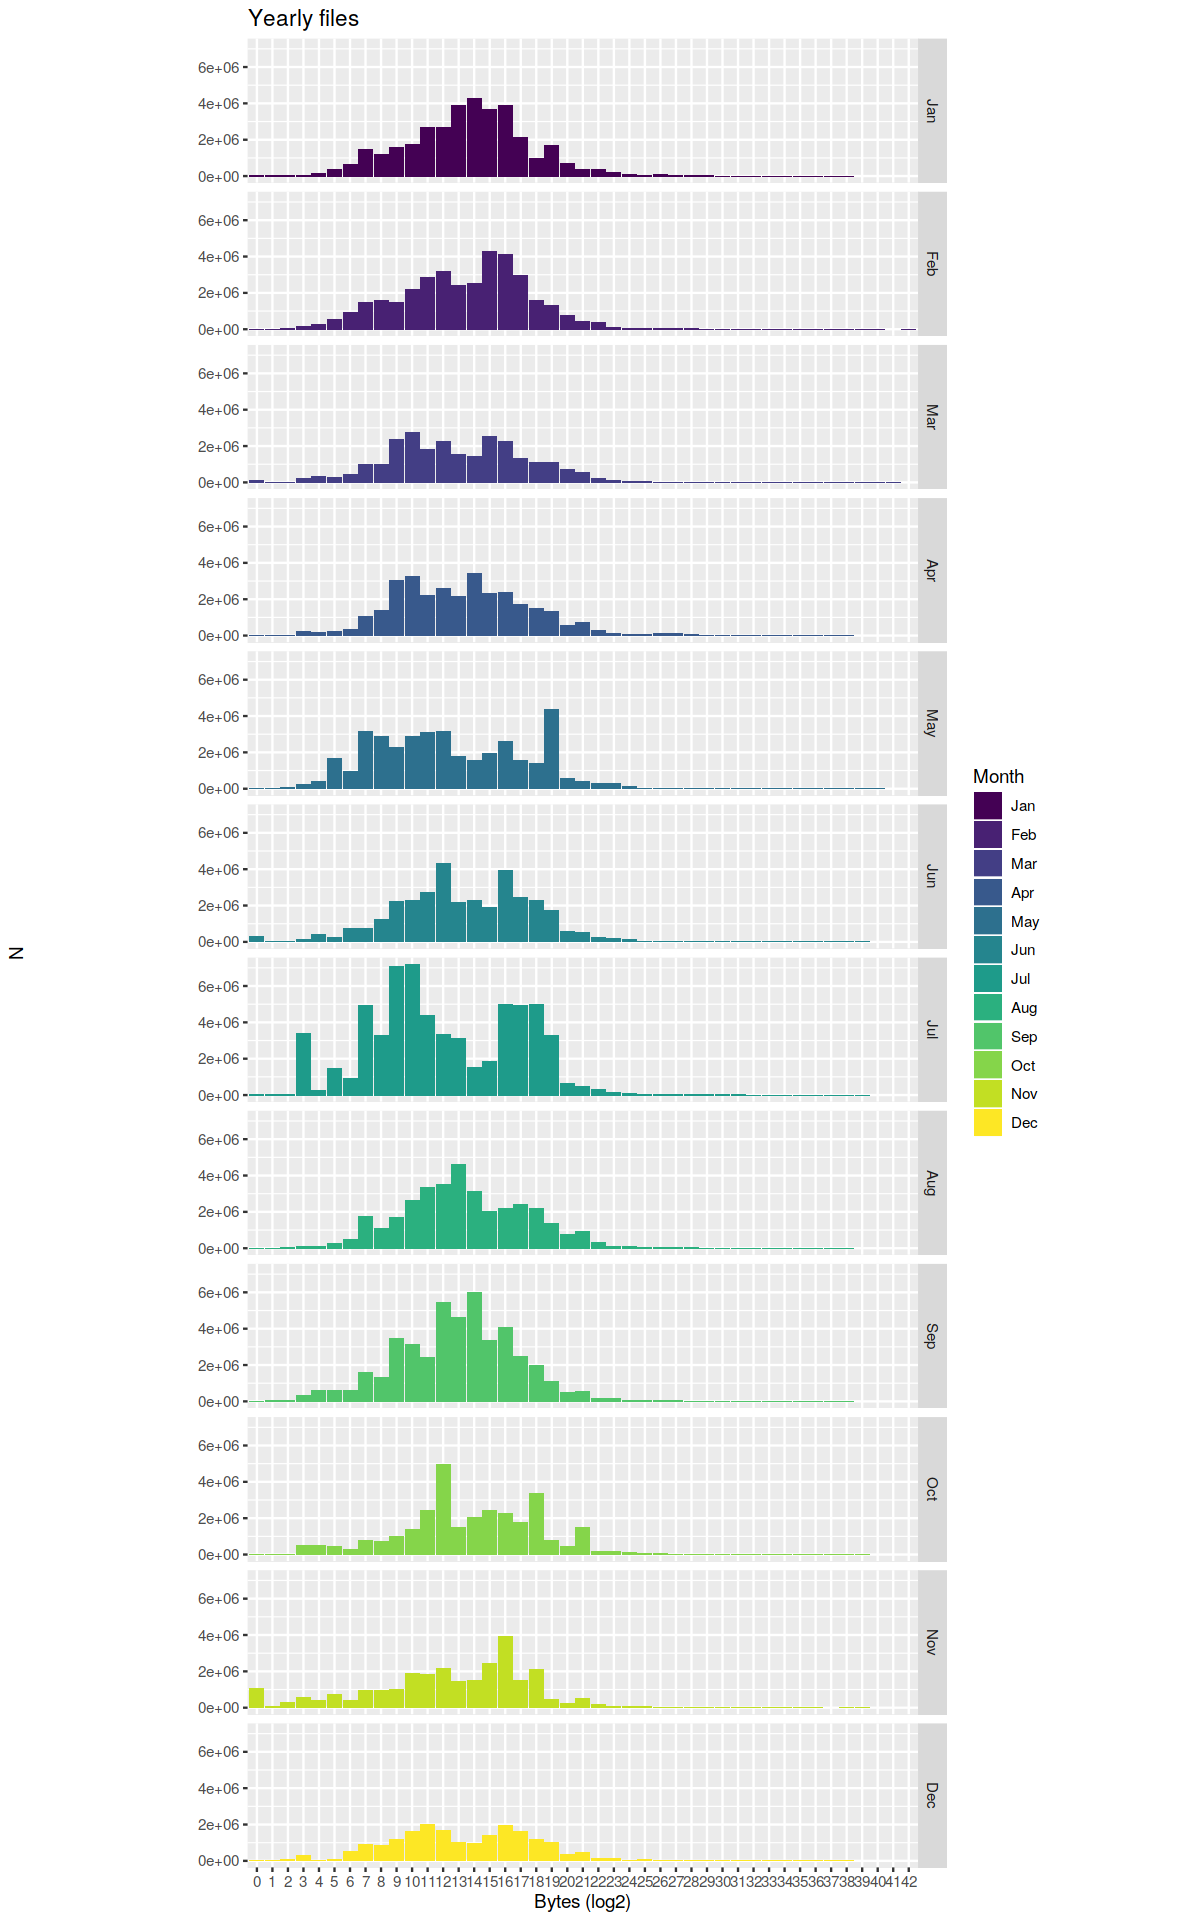

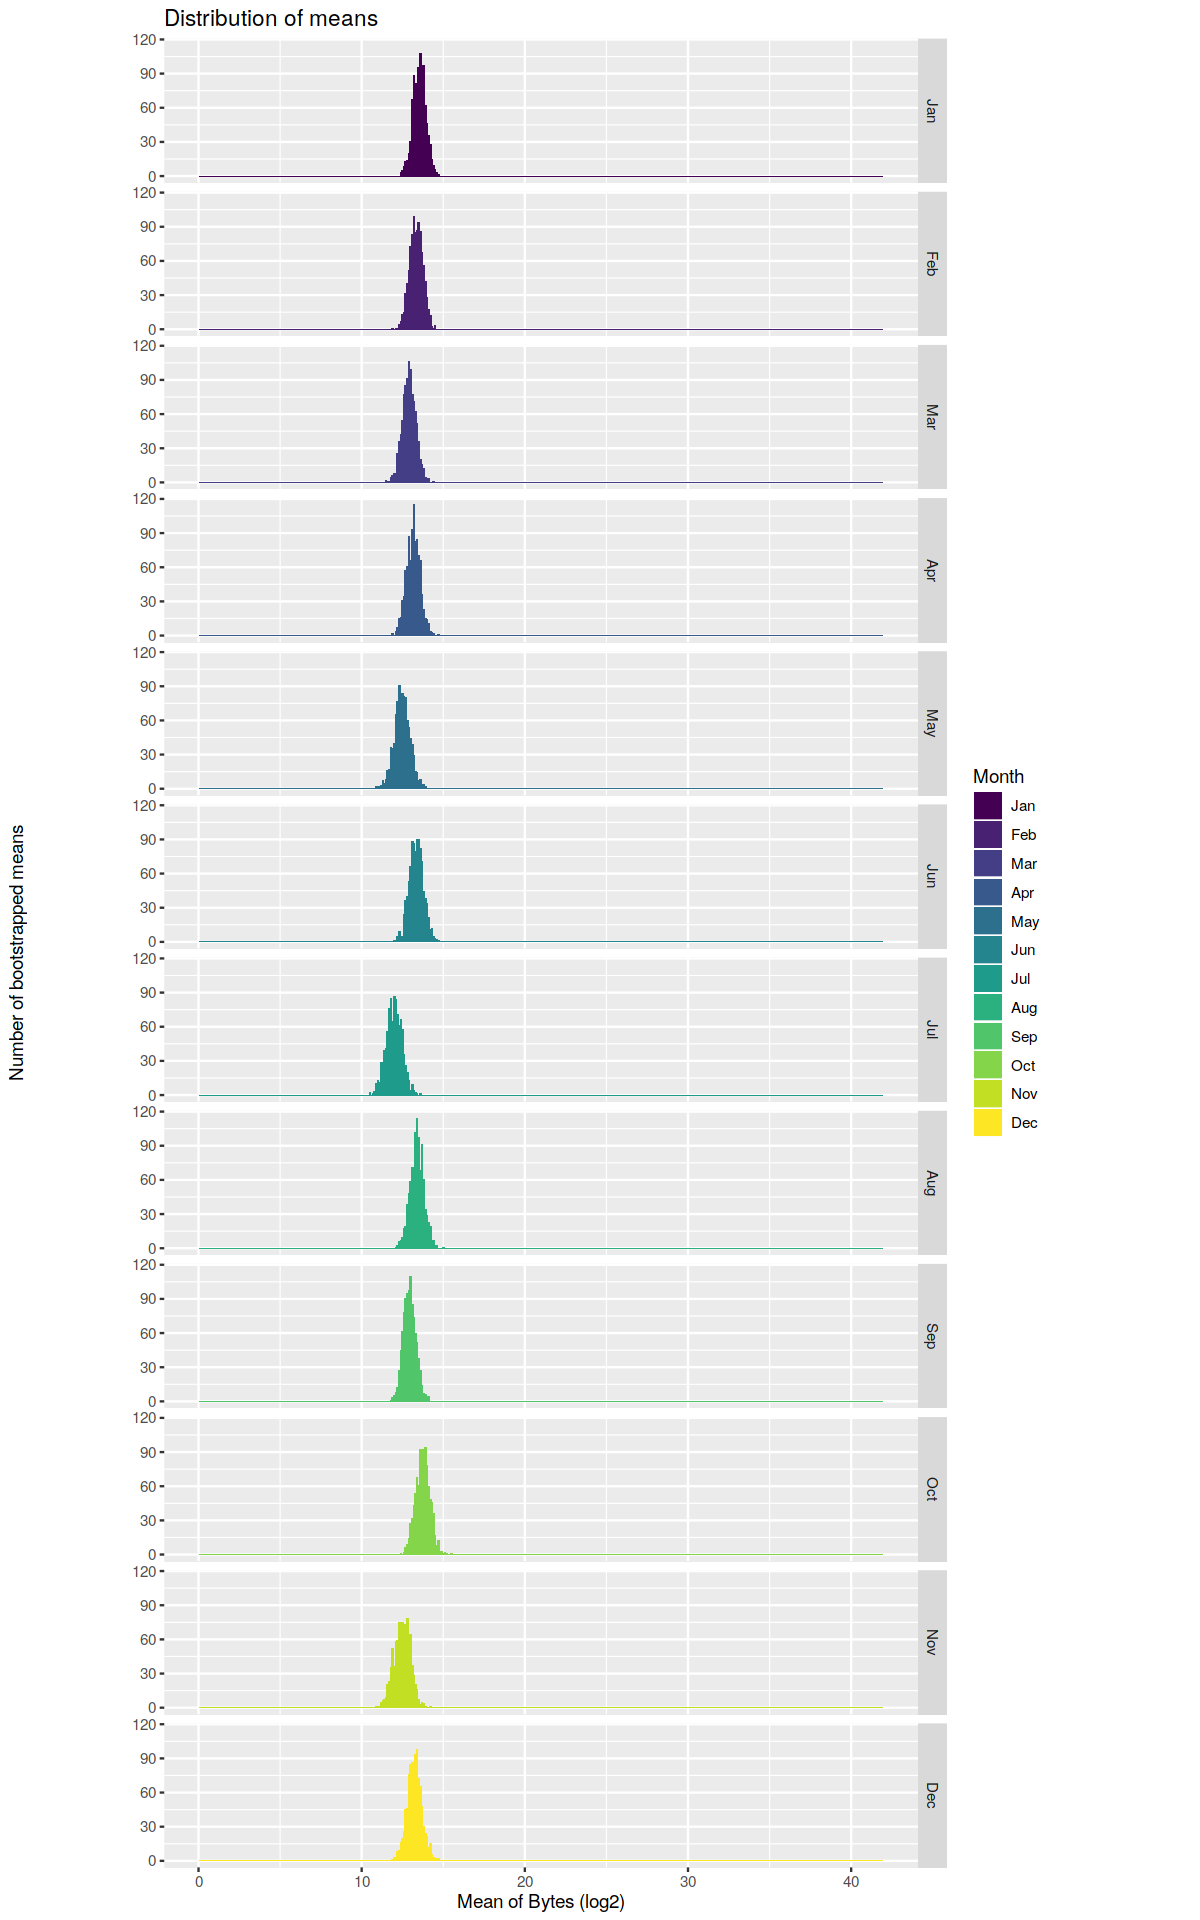

In [19]:
monthly_bytes_sum <- aggregate_filesize_data(filesizes, c('Month','BytesLog2'), c('Files', 'SpaceUsage'), sum)
bootstrapped_monthly_means = bootstrap_byteslog2_mean(monthly_bytes_sum, 'Month', 'Files', n_means=1000)
bootstrapped_monthly_means_distribution <- bootstrapped_monthly_means %>%
    select(-Means) %>%
    unnest()

options(repr.plot.width=10, repr.plot.height=16)

x_limits <- range(as.numeric(levels(monthly_bytes_sum[['BytesLog2']])))

monthly_bytes_sum %>%
    ggplot(aes(x=as.factor(BytesLog2), y=Files, fill=Month)) +
        geom_bar(stat='identity') +
        ylab('N') +
        xlab('Bytes (log2)') +
        ggtitle('Yearly files') +
        facet_grid(rows=vars(Month))

bootstrapped_monthly_means_distribution %>%
    ggplot(aes(x=SampledMeans, fill=Month)) +
        geom_histogram(binwidth=0.1) +
        ylab('Number of bootstrapped means') +
        xlab('Mean of Bytes (log2)') +
        xlim(x_limits) +
        ggtitle('Distribution of means') +
        facet_grid(rows=vars(Month))

## Fitting functions to data

In [20]:
newfiles_yearly_cumsum <- newusage_yearly_sum %>%
    mutate(SpaceUsage=cumsum(SpaceUsage))
newusage_yearly_cumsum <- newusage_yearly_sum %>%
    mutate(SpaceUsage=cumsum(SpaceUsage))

print(newfiles_yearly_cumsum %>%
    ggplot(aes(x=Year, y=SpaceUsage, fill=Year)) +
    geom_col())
print(newusage_yearly_cumsum %>%
    ggplot(aes(x=Year, y=SpaceUsage, fill=Year)) +
    geom_col())

ERROR: Error in eval(lhs, parent, parent): object 'newusage_yearly_sum' not found


Saving 6,67 x 6,67 in image


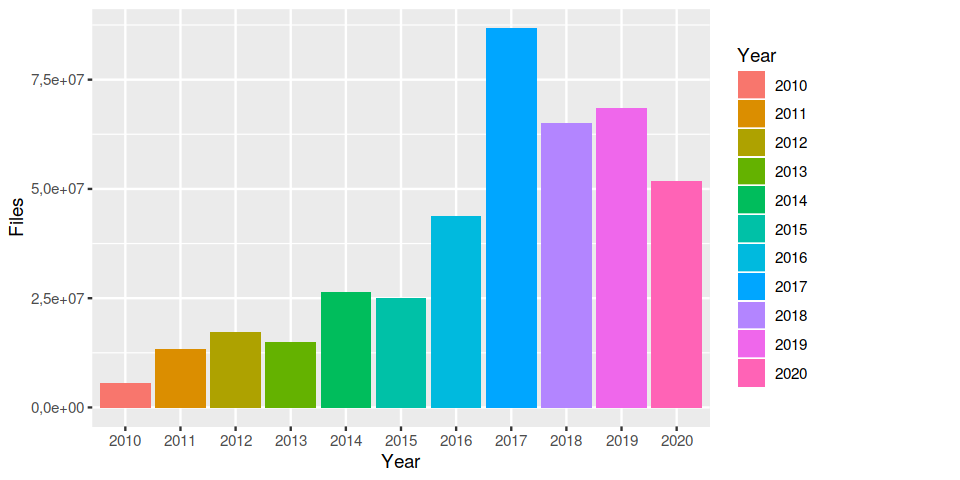

In [14]:
options(repr.plot.width=8, repr.plot.height=4)

newfiles_yearly_plot <-  newfiles_yearly_sum %>%
    mutate(Year=as.factor(Year)) %>%
    ggplot(aes(x=Year, y=Files, fill=Year)) +
    geom_col()

print(newfiles_yearly_plot)

ggsave('newfiles_yearly_sum_r.png')

In [8]:
options(repr.plot.width=12, repr.plot.height=2)

for (year in seq(min(years),max(years))) {
    yearly_data <- filesizes_yearly[filesizes_yearly['year'] == year,] %>%
        mutate(year=as.factor(year))
    print(yearly_data %>%
        ggplot(aes_(~ as.factor(bytes2), ~ n_total, fill=year)) +
            geom_bar(stat='identity', show.legend = FALSE) +
            ylab('N') +
            xlab('Bytes (log2)') +
            ggtitle(year))
}

ERROR: Error in min(years): invalid 'type' (closure) of argument


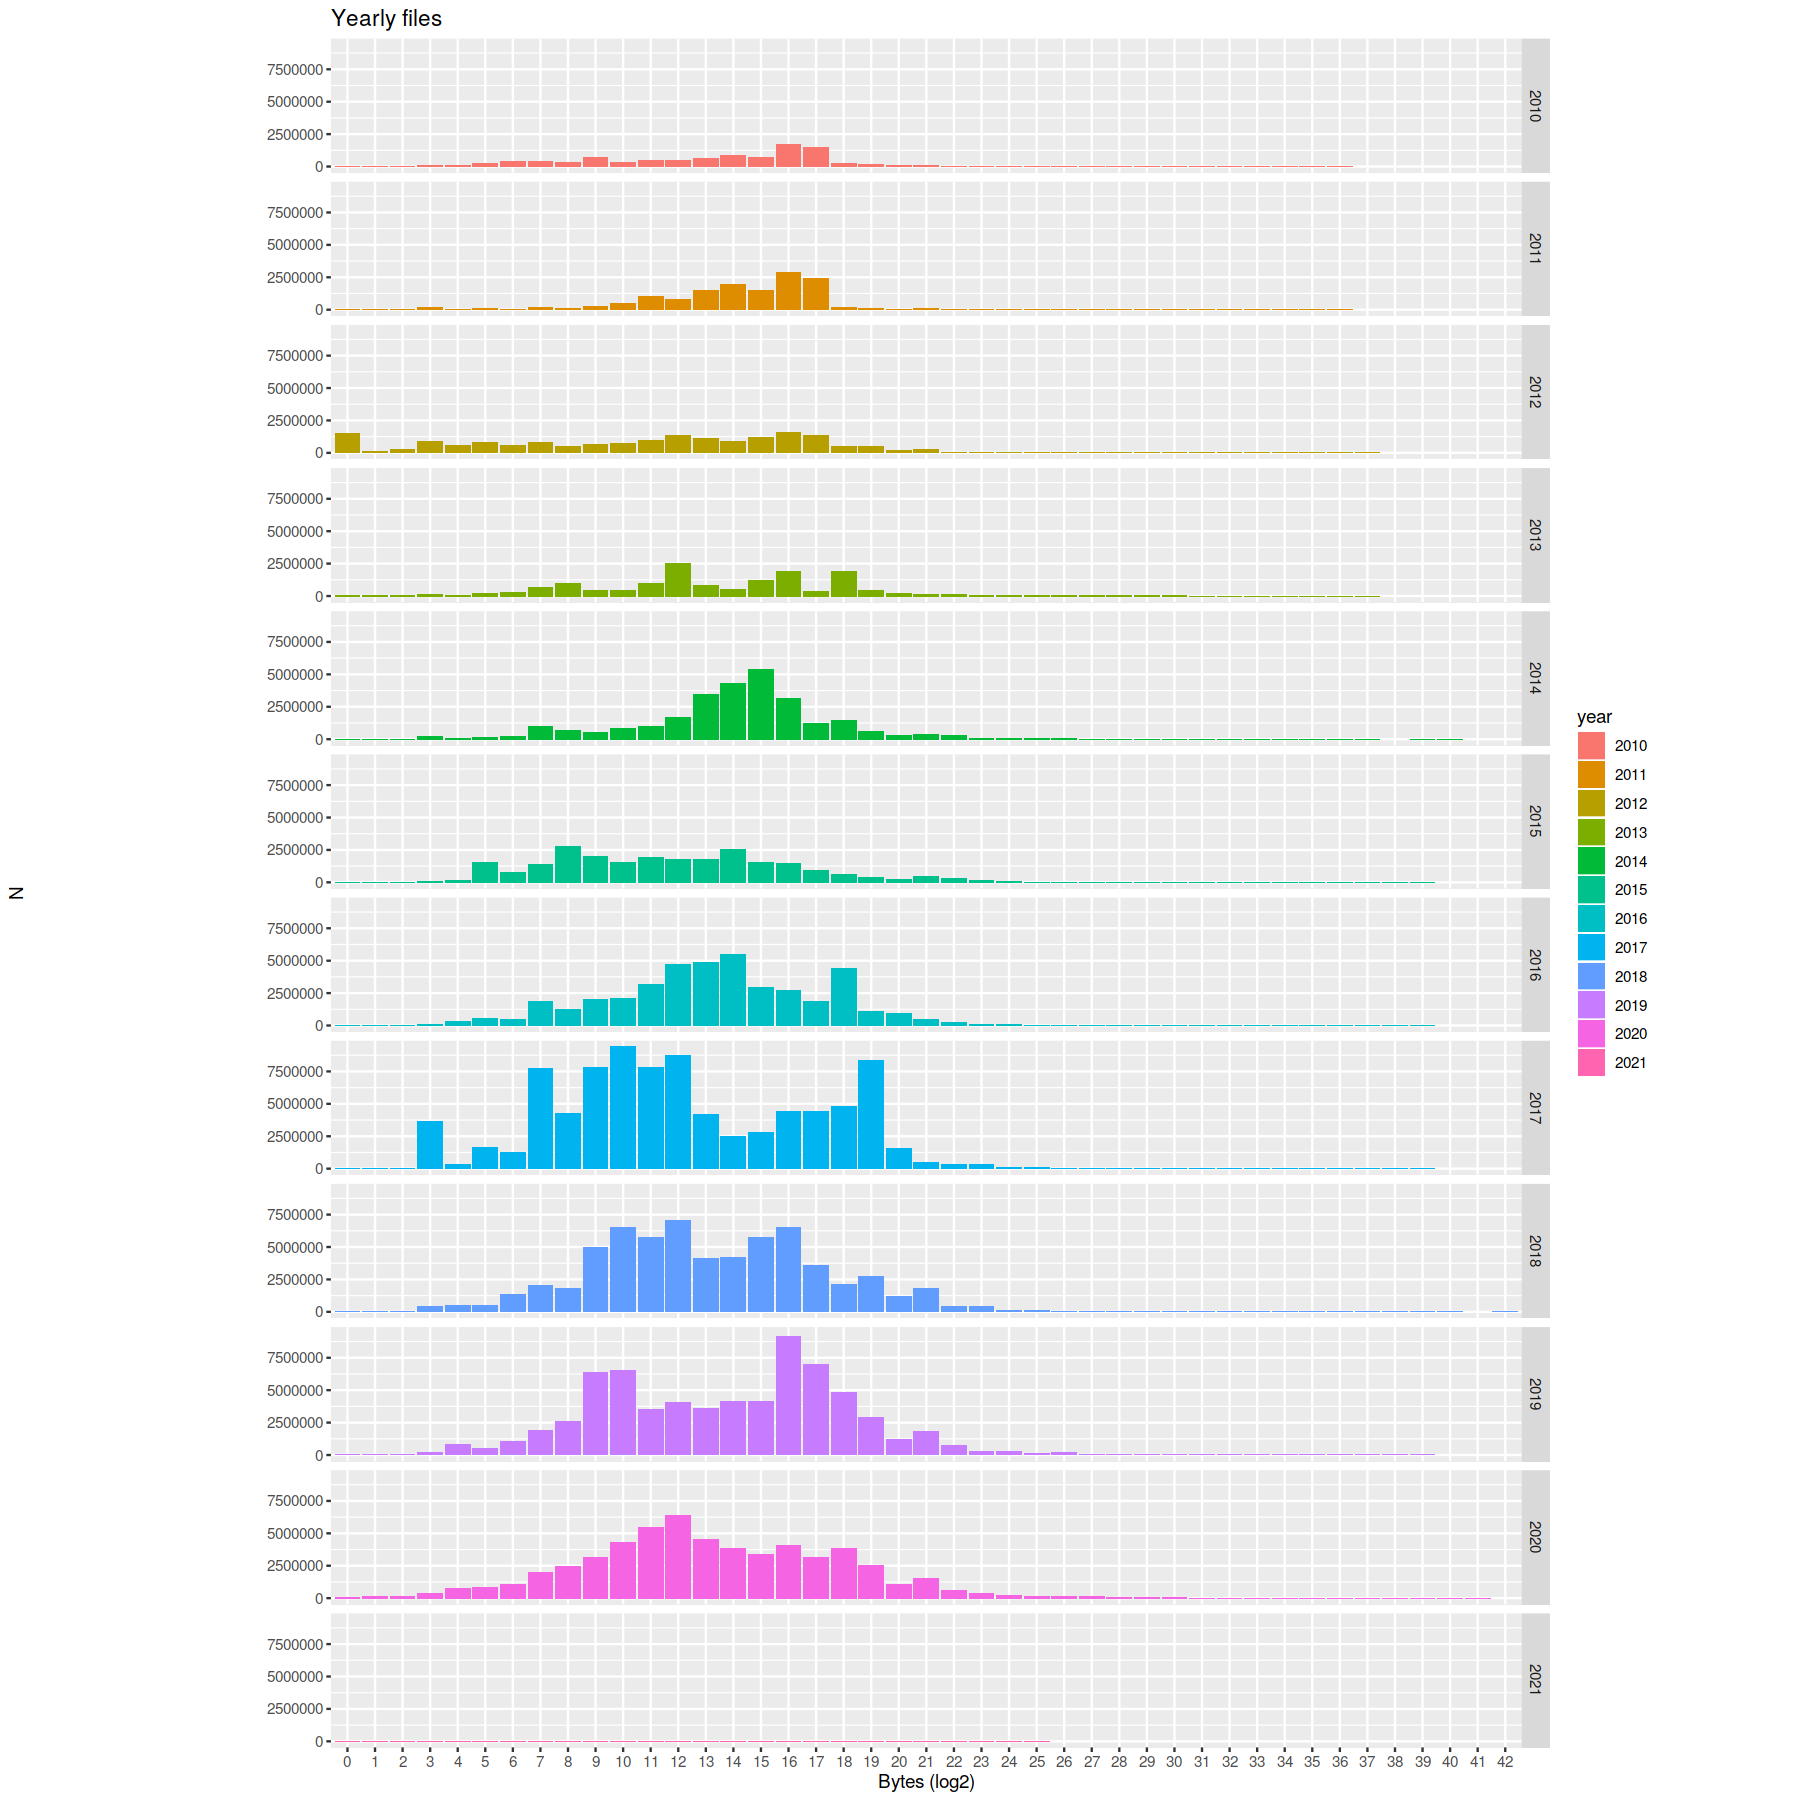

In [90]:
options(repr.plot.width=15, repr.plot.height=15)

filesizes_yearly %>%
    mutate(year=as.factor(year)) %>%
    ggplot(aes(x=as.factor(bytes2), y=n_total, fill=year)) +
        geom_bar(stat='identity') +
        ylab('N') +
        xlab('Bytes (log2)') +
        ggtitle('Yearly files') +
        facet_grid(rows=vars(year))

In [91]:
library(boot)

In [92]:
nsamples <- tibble(sample_number=seq(1000))

In [93]:
filesizes_sampled <- crossing(nsamples, years)

In [94]:
get_bootstrapped_mean <- function(year) {
    yearly_data <- filesizes_yearly %>%
        filter(year==year)
    bytes2 <- yearly_data$bytes2
    n_total <- yearly_data$n_total
    sampled_data <- sample(bytes2, 100, replace=TRUE, prob=n_total)
    return(mean(sampled_data))
}

In [250]:
get_bootstrapped_mean2 <- function(year, n_means=10000) {
    sampled_means <- numeric(n_means)
    years_data <- filesizes_yearly[filesizes_yearly['year'] == year,] %>%
        mutate(year=as.factor(year))
    bytes2 <- years_data$bytes2
    n_total <- years_data$n_total
    for (i in seq(n_means)) {
        sampled_means[[i]] <- sample(bytes2, 100, replace=TRUE, prob=n_total) %>%
            mean()
    }
    return(tibble(sampled_means=sampled_means))
}

In [251]:
get_bootstrapped_mean2(2012) %>%
    summarize(mean=mean(sampled_means))

mean
"10,67666"


In [252]:
get_bootstrapped_mean(2020)

[1] 13,28

In [96]:
time1 = Sys.time()
for (i in seq(10)) {
    filesizes_sampled %>%
        mutate(mean_fs=Vectorize(get_bootstrapped_mean)(year))
}
time2 = Sys.time()
print((time2-time1)/10)

Time difference of 2,202973 secs


In [156]:
time1 = Sys.time()
for (i in seq(10)) {
    years %>%
        mutate(sampled_means=Vectorize(get_bootstrapped_mean2)(year))
}
time2 = Sys.time()
print((time2-time1)/10)

Time difference of 0,9186298 secs


In [253]:
filesizes_sampled <- years %>%
    mutate(sampled_means=map(year, get_bootstrapped_mean2)) %>%
    unnest()

In [254]:
time1 = Sys.time()
for (i in seq(10)) {
    filesizes_sampled %>%
        mutate(mean_fs=Vectorize(get_bootstrapped_mean)(year))
}
time2 = Sys.time()
print((time2-time1)/10)

In [175]:
filesizes_sampled['sampled_means'] <- as.numeric(map(filesizes_sampled$year, get_bootstrapped_mean))

In [255]:
filesizes_sampled %>%
    group_by(year) %>%
    summarize_all(.funs=c(mean))

year,sampled_means
2010,"13,18852"
2011,"14,12835"
2012,"10,66711"
2013,"13,42103"
2014,"14,02680"
2015,"11,72655"
2016,"13,40625"
2017,"12,12566"
2018,"13,13400"
2019,"13,72982"


Warning message:
“Removed 24 rows containing missing values (geom_bar).”

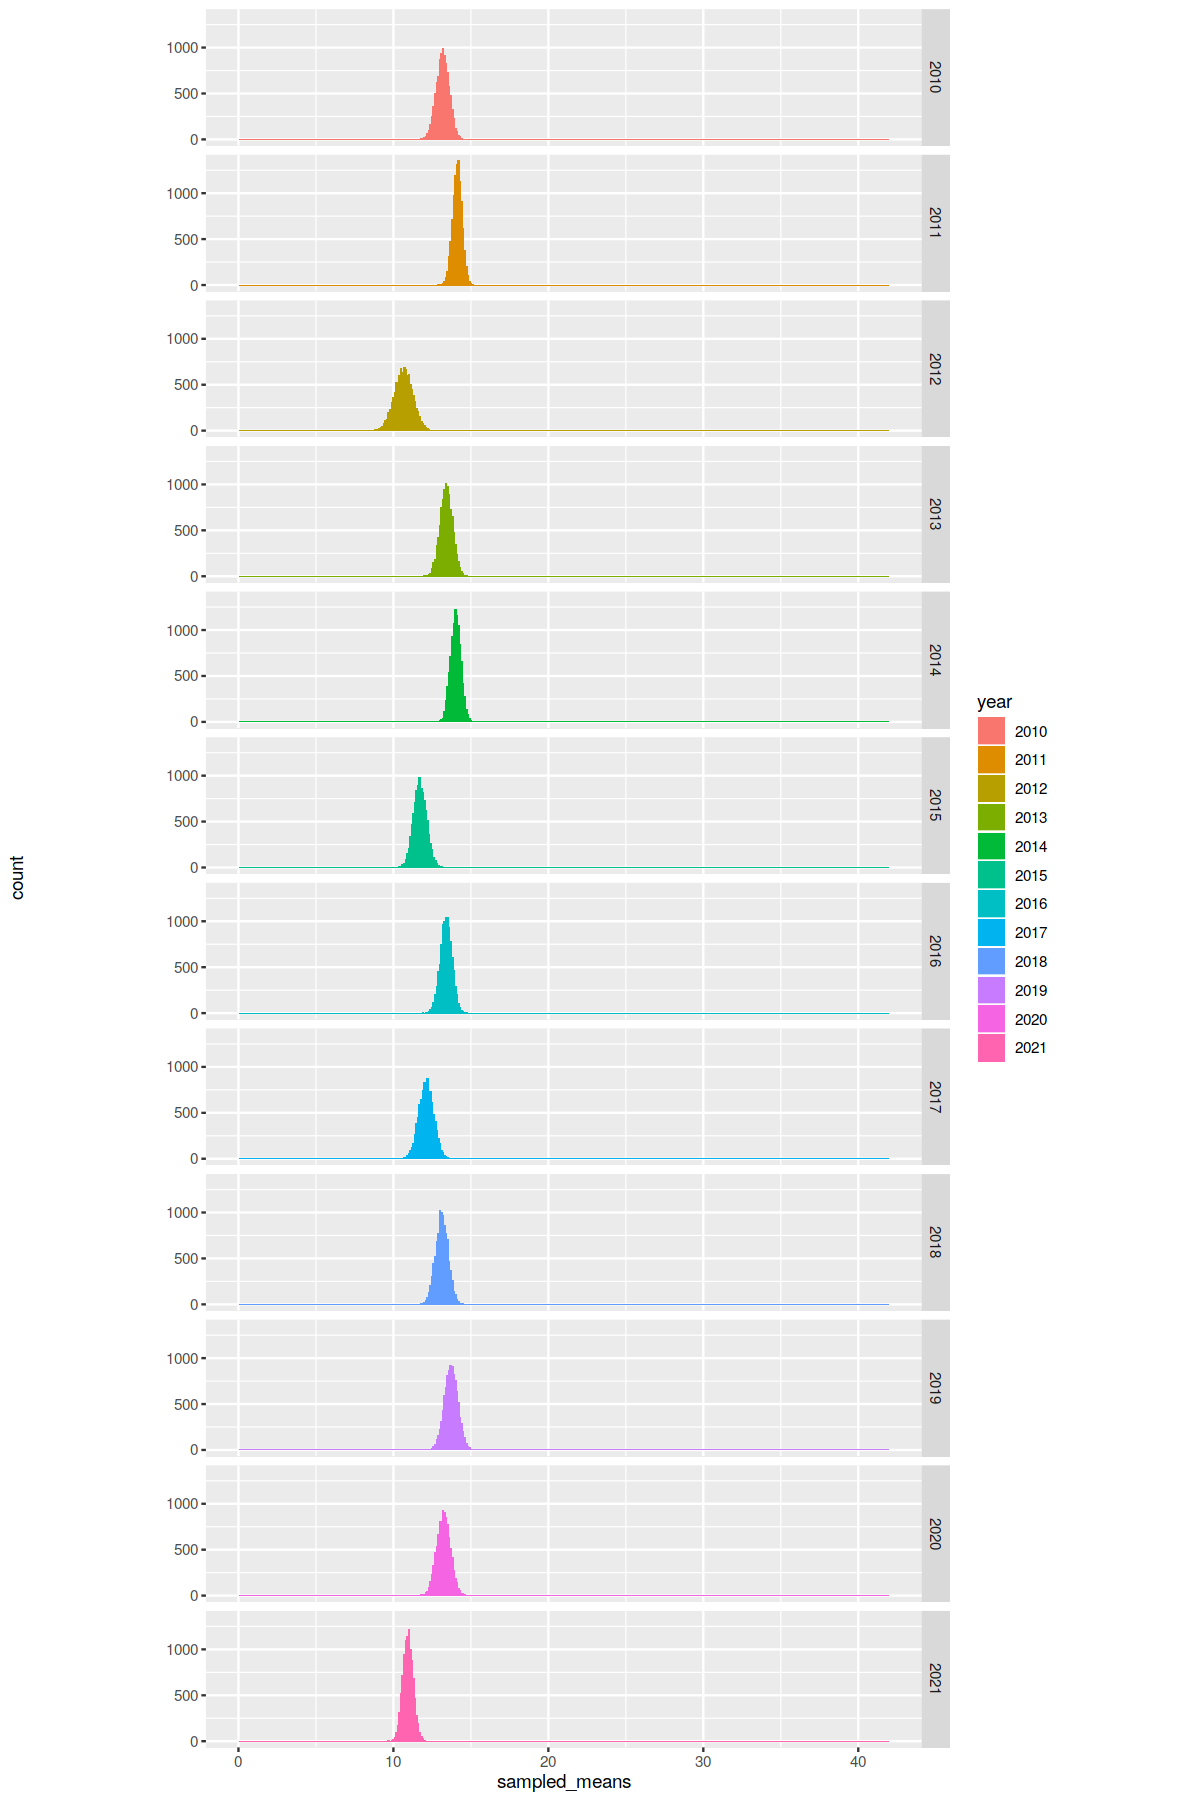

In [256]:
options(repr.plot.width=10, repr.plot.height=15)

filesizes_sampled %>%
    select(year, sampled_means) %>%
    mutate(year=as.factor(year)) %>%
    ggplot(aes(x=sampled_means, fill=year)) +
        geom_histogram(binwidth=0.1) +
        xlim(range(bytes2)) +
#        ylab('N') +
#        xlab('Bytes (log2)') +
#        ggtitle('Yearly files') +
        facet_grid(rows=vars(year))